In [2]:
import pandas as pd
import numpy as np
import requests
import json
from pandas.io.json import json_normalize
from datetime import timedelta, date
import time
import pickle
import glob
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb   

pd.set_option('display.max_columns', 500)

In [5]:
df_game_sub_merged = pd.read_csv("all_mlb_data_for_model.csv")

In [7]:
df_game_sub_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12584 entries, 0 to 12583
Columns: 111 entries, game.id to whip_30_home
dtypes: float64(99), int64(3), object(9)
memory usage: 10.7+ MB


In [6]:
df_game_sub_merged.head()

,game.id,game.scheduled,game.date,game.home.runs,game.away.runs,game.away.lineup,game.home.lineup,game.home_team,game.home.name,game.away_team,game.away.name,game.attendance,game.away.starting_pitcher.era,game.home.starting_pitcher.era,game.away.starting_pitcher.win,game.away.starting_pitcher.loss,game.home.starting_pitcher.loss,game.home.starting_pitcher.win,game.winning.team,game.away.pitching.winpercentage,game.home.pitching.winpercentage,assists_1_away,av_risp_1_away,avg_1_away,era_1_away,error_1_away,fpct_1_away,hit_risp_1_away,k9_1_away,obp_1_away,ops_1_away,pitch_count_1_away,rbi_1_away,runs_1_away,slg_1_away,whip_1_away,assists_7_away,av_risp_7_away,avg_7_away,era_7_away,error_7_away,fpct_7_away,hit_risp_7_away,k9_7_away,obp_7_away,ops_7_away,pitch_count_7_away,rbi_7_away,runs_7_away,slg_7_away,whip_7_away,assists_30_away,av_risp_30_away,avg_30_away,era_30_away,error_30_away,fpct_30_away,hit_risp_30_away,k9_30_away,obp_30_away,ops_30_away,pitch_count_30_away,rbi_30_away,runs_30_away,slg_30_away,whip_30_away,assists_1_home,av_risp_1_home,avg_1_home,era_1_home,error_1_home,fpct_1_home,hit_risp_1_home,k9_1_home,obp_1_home,ops_1_home,pitch_count_1_home,rbi_1_home,runs_1_home,slg_1_home,whip_1_home,assists_7_home,av_risp_7_home,avg_7_home,era_7_home,error_7_home,fpct_7_home,hit_risp_7_home,k9_7_home,obp_7_home,ops_7_home,pitch_count_7_home,rbi_7_home,runs_7_home,slg_7_home,whip_7_home,assists_30_home,av_risp_30_home,avg_30_home,era_30_home,error_30_home,fpct_30_home,hit_risp_30_home,k9_30_home,obp_30_home,ops_30_home,pitch_count_30_home,rbi_30_home,runs_30_home,slg_30_home,whip_30_home
0,083801cc-cf2c-43f1-b78a-27a5d270403d,2015-05-26T00:10:00+00:00,2015-05-26,6,3,[{'id': 'e43136cd-762f-4b3f-8595-4f07e83be3b2'...,[{'id': '43a9d631-5673-4059-9b25-d59290bc32c3'...,ef64da7f-cfaf-4300-87b0-9313386b977c,Dodgers,12079497-e414-450a-8bf2-29f91de646bf,Braves,44680.0,6.136,3.614,0.0,0.0,2.0,2.0,1,NaN,0.500000,NaN,NaN,0.210643,5.5125,0.076923,0.839154,NaN,18.3375,NaN,0.522571,31.0,0.071429,0.142857,0.228500,2.975,NaN,NaN,NaN,2.035714,0.010989,0.697168,NaN,6.750000,NaN,0.455286,12.952381,0.252747,0.252747,0.213176,1.314286,NaN,NaN,NaN,NaN,0.038889,0.930890,NaN,NaN,NaN,0.670067,NaN,0.383333,0.466667,0.350911,NaN,NaN,NaN,0.210643,5.5125,0.076923,0.839154,NaN,18.3375,NaN,0.522571,31.0,0.071429,0.142857,0.228500,2.975,NaN,NaN,NaN,2.035714,0.010989,0.697168,NaN,6.750000,NaN,0.455286,12.952381,0.252747,0.252747,0.213176,1.314286,NaN,NaN,NaN,NaN,0.038889,0.930890,NaN,NaN,NaN,0.670067,NaN,0.383333,0.466667,0.350911,NaN
1,35233f95-2d40-4859-9b59-6736a26b0b69,2015-05-25T17:10:00+00:00,2015-05-25,6,3,[{'id': 'f4b89e5f-baae-4dd4-87b2-1cd75889b48b'...,[{'id': '39212be3-ce0d-4f7f-ab1a-c687ca189edd'...,f246a5e5-afdb-479c-9aaa-c68beeda7af6,Mets,2142e1ba-3b40-445c-b8bb-f1f8b1054220,Phillies,30946.0,7.105,4.850,2.0,1.0,3.0,6.0,1,0.666667,0.666667,NaN,NaN,0.217800,9.3600,0.000000,0.615385,NaN,1.8000,NaN,0.555600,25.8,0.200000,0.200000,0.337800,2.200,NaN,NaN,NaN,5.571429,0.054945,0.767407,NaN,9.150000,NaN,0.569253,15.904762,0.274725,0.340659,0.312286,1.890476,NaN,NaN,NaN,NaN,0.059040,0.909896,NaN,NaN,NaN,0.675481,NaN,0.329630,0.348148,0.358763,NaN,NaN,NaN,0.217800,9.3600,0.000000,0.615385,NaN,1.8000,NaN,0.555600,25.8,0.200000,0.200000,0.337800,2.200,NaN,NaN,NaN,5.571429,0.054945,0.767407,NaN,9.150000,NaN,0.569253,15.904762,0.274725,0.340659,0.312286,1.890476,NaN,NaN,NaN,NaN,0.059040,0.909896,NaN,NaN,NaN,0.675481,NaN,0.329630,0.348148,0.358763,NaN
2,0991650b-dfeb-42f1-9a83-ffc52c51d690,2015-05-25T23:07:00+00:00,2015-05-25,6,0,[{'id': 'aa614a82-e4c7-4129-ba6d-5205b1c9b63d'...,[{'id': 'f11efc76-62f5-4396-b145-e03839fd4d1c'...,1d678440-b4b1-4954-9b39-70afb3ebbcfa,Blue Jays,47f490cd-2f58-4ef7-9dfd-2ad6ba6c1ae8,White Sox,15168.0,5.604,6.061,0.0,3.0,1.0,3.0,1,0.000000,0.750000,NaN,NaN,0.125000,4.5000,0.111111,0.666667,NaN,0.0000,NaN,0.425000,15.5,0.100000,0.100000,0.200000,2.500,NaN,NaN,NaN,3.765286,0.043290,0.778621,NaN,4.186286,NaN,0.531914,36.714286,0.257143,

# Data Cleaning

In [17]:
# These columns had little to no importance in the model according to feature importance
cols_to_drop = ['obp_1_away', 
                'obp_7_away', 
                'obp_30_away', 
                'av_risp_1_away', 
                'av_risp_7_away', 
                'av_risp_30_away',
                'hit_risp_1_away', 
                'hit_risp_7_away', 
                'hit_risp_30_away',
                'obp_1_home', 
                'obp_7_home', 
                'obp_30_home',
                'av_risp_1_home', 
                'av_risp_7_home', 
                'av_risp_30_home',
                'hit_risp_1_home', 
                'hit_risp_7_home', 
                'hit_risp_30_home',
                'game.scheduled', 
                'game.home.runs', 
                'game.away.runs', 
                'game.away.lineup', 
                'game.home.lineup', 
                'game.home_team', 
                'game.away_team', 
                'game.attendance',
                'assists_1_away', 
                'assists_7_away', 
                'avg_7_away', 
                'assists_30_away', 
                'avg_30_away',
                'assists_1_home', 
                'assists_7_home', 
                'avg_7_home', 
                'assists_30_home', 
                'avg_30_home']

# Drop the columns above
df_baseline = df_game_sub_merged.drop(columns = cols_to_drop)

# Drop game ID
df_baseline = df_baseline.drop(columns = 'game.id')

# Create target
target = df_baseline['game.winning.team']
df_baseline.drop(labels=['game.winning.team'], axis=1,inplace = True)
df_baseline.insert(0, 'game.winning.team', target)

# Create column that contains the day of the week game is played
df_baseline['game.week.day'] = pd.to_datetime(df_baseline['game.date']).dt.day_name()

# Keep only rows with all values filled
df_baseline = df_baseline.dropna().reset_index(drop = True)

# One Hot Encode categorical variables
df_baseline = pd.get_dummies(df_baseline, columns = ['game.home.name', 'game.away.name', 'game.week.day'])

In [18]:
df_baseline.head()

,game.winning.team,game.date,game.away.starting_pitcher.era,game.home.starting_pitcher.era,game.away.starting_pitcher.win,game.away.starting_pitcher.loss,game.home.starting_pitcher.loss,game.home.starting_pitcher.win,game.away.pitching.winpercentage,game.home.pitching.winpercentage,avg_1_away,era_1_away,error_1_away,fpct_1_away,k9_1_away,ops_1_away,pitch_count_1_away,rbi_1_away,runs_1_away,slg_1_away,whip_1_away,era_7_away,error_7_away,fpct_7_away,k9_7_away,ops_7_away,pitch_count_7_away,rbi_7_away,runs_7_away,slg_7_away,whip_7_away,era_30_away,error_30_away,fpct_30_away,k9_30_away,ops_30_away,pitch_count_30_away,rbi_30_away,runs_30_away,slg_30_away,whip_30_away,avg_1_home,era_1_home,error_1_home,fpct_1_home,k9_1_home,ops_1_home,pitch_count_1_home,rbi_1_home,runs_1_home,slg_1_home,whip_1_home,era_7_home,error_7_home,fpct_7_home,k9_7_home,ops_7_home,pitch_count_7_home,rbi_7_home,runs_7_home,slg_7_home,whip_7_home,era_30_home,error_30_home,fpct_30_home,k9_30_home,ops_30_home,pitch_count_30_home,rbi_30_home,runs_30_home,slg_30_home,whip_30_home,game.home.name_Angels,game.home.name_Astros,game.home.name_Athletics,game.home.name_Blue Jays,game.home.name_Braves,game.home.name_Brewers,game.home.name_Cardinals,game.home.name_Cubs,game.home.name_Diamondbacks,game.home.name_Dodgers,game.home.name_Giants,game.home.name_Indians,game.home.name_Mariners,game.home.name_Marlins,game.home.name_Mets,game.home.name_Nationals,game.home.name_Orioles,game.home.name_Padres,game.home.name_Phillies,game.home.name_Pirates,game.home.name_Rangers,game.home.name_Rays,game.home.name_Red Sox,game.home.name_Reds,game.home.name_Rockies,game.home.name_Royals,game.home.name_Tigers,game.home.name_Twins,game.home.name_White Sox,game.home.name_Yankees,game.away.name_Angels,game.away.name_Astros,game.away.name_Athletics,game.away.name_Blue Jays,game.away.name_Braves,game.away.name_Brewers,game.away.name_Cardinals,game.away.name_Cubs,game.away.name_Diamondbacks,game.away.name_Dodgers,game.away.name_Giants,game.away.name_Indians,game.away.name_Mariners,game.away.name_Marlins,game.away.name_Mets,game.away.name_Nationals,game.away.name_Orioles,game.away.name_Padres,game.away.name_Phillies,game.away.name_Pirates,game.away.name_Rangers,game.away.name_Rays,game.away.name_Red Sox,game.away.name_Reds,game.away.name_Rockies,game.away.name_Royals,game.away.name_Tigers,game.away.name_Twins,game.away.name_White Sox,game.away.name_Yankees,game.week.day_Friday,game.week.day_Monday,game.week.day_Saturday,game.week.day_Sunday,game.week.day_Thursday,game.week.day_Tuesday,game.week.day_Wednesday
0,1,2015-09-29,4.400,4.232,12.0,8.0,7.0,7.0,0.600000,0.500000,0.236750,0.56250,0.020833,0.809021,3.506625,0.621227,33.125000,0.227273,0.272727,0.350386,1.164588,4.454077,0.040064,0.656915,9.294589,0.668214,32.151786,0.350649,0.396104,0.373578,1.406146,4.429043,0.042203,0.699396,8.34735,0.552051,22.844444,0.306741,0.349556,0.306841,1.383094,0.236750,0.56250,0.020833,0.809021,3.506625,0.621227,33.125000,0.227273,0.272727,0.350386,1.164588,4.454077,0.040064,0.656915,9.294589,0.668214,32.151786,0.350649,0.396104,0.373578,1.406146,4.429043,0.042203,0.699396,8.34735,0.552051,22.844444,0.306741,0.349556,0.306841,1.383094,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,1,2015-05-30,4.528,4.263,4.0,2.0,1.0,1.0,0.666667,0.500000,0.100000,2.60525,0.000000,0.846154,2.486250,0.356667,33.000000,0.133333,0.133333,0.113333,0.815800,1.637214,0.054422,0.766398,7.425321,0.564061,35.285714,0.193878,0.173469,0.324459,1.000471,0.000000,0.055708,0.874847,9.00000,0.702056,9.000000,0.359259,0.451852,0.401267,1.000000,0.100000,2.60525,0.000000,0.846154,2.486250,0.356667,33.000000,0.133333,0.133333,0.113333,0.815800,1.637214,0.054422,0.766398,7.425321,0.564061,35.285714,0.193878,0.173469,0.324459,1.000471,0.000000,0.055708,0.874847,9.00000,0.702056,9.000000,0.359259,0.451852,0.401267,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [19]:
# Predicting the home team always wins: Returns a list of 1's 
def home_predict(x_array):
    return(['1' for x in range(len(x_array))])

# Predicting the away team always wins: Returns a list of 0's 
def away_predict(x_array):
    return(['0' for x in range(len(x_array))])

In [20]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(df_baseline.iloc[:, 1:], df_baseline.iloc[:, 0], 
                                                    test_size = 0.2, random_state=42)

In [21]:
df_baseline.head()

,game.winning.team,game.date,game.away.starting_pitcher.era,game.home.starting_pitcher.era,game.away.starting_pitcher.win,game.away.starting_pitcher.loss,game.home.starting_pitcher.loss,game.home.starting_pitcher.win,game.away.pitching.winpercentage,game.home.pitching.winpercentage,avg_1_away,era_1_away,error_1_away,fpct_1_away,k9_1_away,ops_1_away,pitch_count_1_away,rbi_1_away,runs_1_away,slg_1_away,whip_1_away,era_7_away,error_7_away,fpct_7_away,k9_7_away,ops_7_away,pitch_count_7_away,rbi_7_away,runs_7_away,slg_7_away,whip_7_away,era_30_away,error_30_away,fpct_30_away,k9_30_away,ops_30_away,pitch_count_30_away,rbi_30_away,runs_30_away,slg_30_away,whip_30_away,avg_1_home,era_1_home,error_1_home,fpct_1_home,k9_1_home,ops_1_home,pitch_count_1_home,rbi_1_home,runs_1_home,slg_1_home,whip_1_home,era_7_home,error_7_home,fpct_7_home,k9_7_home,ops_7_home,pitch_count_7_home,rbi_7_home,runs_7_home,slg_7_home,whip_7_home,era_30_home,error_30_home,fpct_30_home,k9_30_home,ops_30_home,pitch_count_30_home,rbi_30_home,runs_30_home,slg_30_home,whip_30_home,game.home.name_Angels,game.home.name_Astros,game.home.name_Athletics,game.home.name_Blue Jays,game.home.name_Braves,game.home.name_Brewers,game.home.name_Cardinals,game.home.name_Cubs,game.home.name_Diamondbacks,game.home.name_Dodgers,game.home.name_Giants,game.home.name_Indians,game.home.name_Mariners,game.home.name_Marlins,game.home.name_Mets,game.home.name_Nationals,game.home.name_Orioles,game.home.name_Padres,game.home.name_Phillies,game.home.name_Pirates,game.home.name_Rangers,game.home.name_Rays,game.home.name_Red Sox,game.home.name_Reds,game.home.name_Rockies,game.home.name_Royals,game.home.name_Tigers,game.home.name_Twins,game.home.name_White Sox,game.home.name_Yankees,game.away.name_Angels,game.away.name_Astros,game.away.name_Athletics,game.away.name_Blue Jays,game.away.name_Braves,game.away.name_Brewers,game.away.name_Cardinals,game.away.name_Cubs,game.away.name_Diamondbacks,game.away.name_Dodgers,game.away.name_Giants,game.away.name_Indians,game.away.name_Mariners,game.away.name_Marlins,game.away.name_Mets,game.away.name_Nationals,game.away.name_Orioles,game.away.name_Padres,game.away.name_Phillies,game.away.name_Pirates,game.away.name_Rangers,game.away.name_Rays,game.away.name_Red Sox,game.away.name_Reds,game.away.name_Rockies,game.away.name_Royals,game.away.name_Tigers,game.away.name_Twins,game.away.name_White Sox,game.away.name_Yankees,game.week.day_Friday,game.week.day_Monday,game.week.day_Saturday,game.week.day_Sunday,game.week.day_Thursday,game.week.day_Tuesday,game.week.day_Wednesday
0,1,2015-09-29,4.400,4.232,12.0,8.0,7.0,7.0,0.600000,0.500000,0.236750,0.56250,0.020833,0.809021,3.506625,0.621227,33.125000,0.227273,0.272727,0.350386,1.164588,4.454077,0.040064,0.656915,9.294589,0.668214,32.151786,0.350649,0.396104,0.373578,1.406146,4.429043,0.042203,0.699396,8.34735,0.552051,22.844444,0.306741,0.349556,0.306841,1.383094,0.236750,0.56250,0.020833,0.809021,3.506625,0.621227,33.125000,0.227273,0.272727,0.350386,1.164588,4.454077,0.040064,0.656915,9.294589,0.668214,32.151786,0.350649,0.396104,0.373578,1.406146,4.429043,0.042203,0.699396,8.34735,0.552051,22.844444,0.306741,0.349556,0.306841,1.383094,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,1,2015-05-30,4.528,4.263,4.0,2.0,1.0,1.0,0.666667,0.500000,0.100000,2.60525,0.000000,0.846154,2.486250,0.356667,33.000000,0.133333,0.133333,0.113333,0.815800,1.637214,0.054422,0.766398,7.425321,0.564061,35.285714,0.193878,0.173469,0.324459,1.000471,0.000000,0.055708,0.874847,9.00000,0.702056,9.000000,0.359259,0.451852,0.401267,1.000000,0.100000,2.60525,0.000000,0.846154,2.486250,0.356667,33.000000,0.133333,0.133333,0.113333,0.815800,1.637214,0.054422,0.766398,7.425321,0.564061,35.285714,0.193878,0.173469,0.324459,1.000471,0.000000,0.055708,0.874847,9.00000,0.702056,9.000000,0.359259,0.451852,0.401267,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [22]:
### Random Forest ###
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(n_estimators = 600, max_depth = 8)
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)

print("Train Accuracy: ", accuracy_score(y_train, rf.predict(X_train)))
print("Test Accuracy: ", accuracy_score(y_test, y_predict))
print("Home Model Accuracy: ", accuracy_score(y_test, home_predict(y_test)))
print("Cross Validation Score: ", np.mean(cross_val_score(rf, X_train, y_train, cv = 10)))

ValueError: could not convert string to float: '2017-08-12'

# XGBoost Modeling

In [28]:
df_game_sub_merged.head()

,game.id,game.scheduled,game.date,game.home.runs,game.away.runs,game.away.lineup,game.home.lineup,game.home_team,game.home.name,game.away_team,game.away.name,game.attendance,game.away.starting_pitcher.era,game.home.starting_pitcher.era,game.away.starting_pitcher.win,game.away.starting_pitcher.loss,game.home.starting_pitcher.loss,game.home.starting_pitcher.win,game.winning.team,game.away.pitching.winpercentage,game.home.pitching.winpercentage,away.team.league,home.team.league,assists_1_away,av_risp_1_away,avg_1_away,era_1_away,error_1_away,fpct_1_away,hit_risp_1_away,k9_1_away,obp_1_away,ops_1_away,pitch_count_1_away,rbi_1_away,runs_1_away,slg_1_away,whip_1_away,assists_7_away,av_risp_7_away,avg_7_away,era_7_away,error_7_away,fpct_7_away,hit_risp_7_away,k9_7_away,obp_7_away,ops_7_away,pitch_count_7_away,rbi_7_away,runs_7_away,slg_7_away,whip_7_away,assists_30_away,av_risp_30_away,avg_30_away,era_30_away,error_30_away,fpct_30_away,hit_risp_30_away,k9_30_away,obp_30_away,ops_30_away,pitch_count_30_away,rbi_30_away,runs_30_away,slg_30_away,whip_30_away,assists_1_home,av_risp_1_home,avg_1_home,era_1_home,error_1_home,fpct_1_home,hit_risp_1_home,k9_1_home,obp_1_home,ops_1_home,pitch_count_1_home,rbi_1_home,runs_1_home,slg_1_home,whip_1_home,assists_7_home,av_risp_7_home,avg_7_home,era_7_home,error_7_home,fpct_7_home,hit_risp_7_home,k9_7_home,obp_7_home,ops_7_home,pitch_count_7_home,rbi_7_home,runs_7_home,slg_7_home,whip_7_home,assists_30_home,av_risp_30_home,avg_30_home,era_30_home,error_30_home,fpct_30_home,hit_risp_30_home,k9_30_home,obp_30_home,ops_30_home,pitch_count_30_home,rbi_30_home,runs_30_home,slg_30_home,whip_30_home
0,083801cc-cf2c-43f1-b78a-27a5d270403d,2015-05-26T00:10:00+00:00,2015-05-26,6,3,[{'id': 'e43136cd-762f-4b3f-8595-4f07e83be3b2'...,[{'id': '43a9d631-5673-4059-9b25-d59290bc32c3'...,ef64da7f-cfaf-4300-87b0-9313386b977c,Dodgers,12079497-e414-450a-8bf2-29f91de646bf,Braves,44680.0,6.136,3.614,0.0,0.0,2.0,2.0,1,NaN,0.500000,National,National,NaN,NaN,0.210643,5.512500,0.076923,0.839154,NaN,18.3375,NaN,0.522571,31.000000,0.071429,0.142857,0.228500,2.975000,NaN,NaN,NaN,2.035714,0.010989,0.697168,NaN,6.750000,NaN,0.455286,12.952381,0.252747,0.252747,0.213176,1.314286,NaN,NaN,NaN,NaN,0.038889,0.930890,NaN,NaN,NaN,0.670067,NaN,0.383333,0.466667,0.350911,NaN,NaN,NaN,0.210643,5.512500,0.076923,0.839154,NaN,18.3375,NaN,0.522571,31.000000,0.071429,0.142857,0.228500,2.975000,NaN,NaN,NaN,2.035714,0.010989,0.697168,NaN,6.750000,NaN,0.455286,12.952381,0.252747,0.252747,0.213176,1.314286,NaN,NaN,NaN,NaN,0.038889,0.930890,NaN,NaN,NaN,0.670067,NaN,0.383333,0.466667,0.350911,NaN
1,7ea3f5f4-fb8d-429f-9d1e-bb2c1f62b29e,2015-05-27T02:10:00+00:00,2015-05-27,8,0,[{'id': 'e43136cd-762f-4b3f-8595-4f07e83be3b2'...,[{'id': '43a9d631-5673-4059-9b25-d59290bc32c3'...,ef64da7f-cfaf-4300-87b0-9313386b977c,Dodgers,12079497-e414-450a-8bf2-29f91de646bf,Braves,40667.0,3.908,4.320,4.0,1.0,3.0,2.0,1,0.800000,0.400000,National,National,NaN,NaN,0.233300,9.234000,0.000000,0.800000,NaN,11.2815,NaN,0.533300,85.000000,0.300000,0.300000,0.258300,1.305200,NaN,NaN,NaN,6.120357,0.028571,0.868229,NaN,7.720071,NaN,0.488295,91.928571,0.319048,0.285714,0.224262,1.476593,NaN,NaN,NaN,NaN,0.046667,0.935313,NaN,NaN,NaN,0.702640,NaN,0.420000,0.520000,0.365093,NaN,NaN,NaN,0.233300,9.234000,0.000000,0.800000,NaN,11.2815,NaN,0.533300,85.000000,0.300000,0.300000,0.258300,1.305200,NaN,NaN,NaN,6.120357,0.028571,0.868229,NaN,7.720071,NaN,0.488295,91.928571,0.319048,0.285714,0.224262,1.476593,NaN,NaN,NaN,NaN,0.046667,0.935313,NaN,NaN,NaN,0.702640,NaN,0.420000,0.520000,0.365093,NaN
2,1c8a2da6-bd91-4b68-8f91-8ff695865091,2015-05-28T02:10:00+00:00,2015-05-28,2,3,[{'id': 'e43136cd-762f-4b3f-8595-4f07e83be3b2'...,[{'id': '43a9d631-5673-4059-9b25-d59290bc32c3'...,ef64da7f-cfaf-4300-87b0-9313386b977c,Dodgers,12079497-e414-450a-8bf2-29f91de646bf,Braves,37837.0,3.830,1.475,2.0,2.0,1.0,5.0,0,0.500000,0.833333,National,National,NaN,NaN,0.102538,0.428667,0.000000,0.818182,NaN,15.4290,NaN,0.

In [29]:
cols_to_drop = ['obp_1_away', 'obp_7_away', 'obp_30_away', 
'av_risp_1_away', 'av_risp_7_away', 'av_risp_30_away',
'hit_risp_1_away', 'hit_risp_7_away', 'hit_risp_30_away',
'obp_1_home', 'obp_7_home', 'obp_30_home',
'av_risp_1_home', 'av_risp_7_home', 'av_risp_30_home',
'hit_risp_1_home', 'hit_risp_7_home', 'hit_risp_30_home',
'game.scheduled', 'game.home.runs', 'game.away.runs',
'game.away.lineup', 'game.home.lineup', 'game.home_team', 'game.away_team', 'game.attendance',
'assists_1_away', 'assists_7_away', 'avg_7_away', 'assists_30_away', 'avg_30_away',
'assists_1_home', 'assists_7_home', 'avg_7_home', 'assists_30_home', 'avg_30_home']


df_baseline = df_game_sub_merged.drop(columns = cols_to_drop)
#df_game_sub_merged[df_game_sub_merged.isnull().any(axis = 1)]


# Create target
target = df_baseline['game.winning.team']
df_baseline.drop(labels=['game.winning.team'], axis=1,inplace = True)
df_baseline.insert(0, 'game.winning.team', target)

# Add Day of the Week
df_baseline['game.week.day'] = pd.to_datetime(df_baseline['game.date']).dt.day_name()

#df_baseline.head()
#df_baseline.info() 

df_baseline = df_baseline.dropna().reset_index(drop = True)
df_baseline = pd.get_dummies(df_baseline, columns = ['game.home.name', 'game.away.name', 'away.team.league', 'home.team.league', 'game.week.day'])

In [30]:
df_baseline.shape

(8093, 144)

In [31]:
# Creating Train and Test Sets
df_19 = df_baseline[pd.to_datetime(df_baseline['game.date']).dt.year > 2018]
test = df_19.drop('game.date', axis = 1)
test = test.drop('game.id', axis = 1)

df_train = df_baseline[pd.to_datetime(df_baseline['game.date']).dt.year <= 2018]
train = df_train.drop('game.date', axis = 1)
train = train.drop('game.id', axis = 1)

X_train = train.iloc[:, 1:]
y_train = train['game.winning.team']

X_test = test.iloc[:, 1:]
y_test = test['game.winning.team']

In [32]:
### XGBOOST with CATEGORICAL VARIABLES ###

def home_predict(x_array):
    return(['1' for x in range(len(x_array))])

gbm_final = xgb.XGBClassifier( 
                        n_estimators= 30000,
                        max_depth= 7, #9
                        objective='binary:logistic', #new objective
                        learning_rate= 0.05, # 0.05
                        subsample= .8,
                        min_child_weight= 3,
                        colsample_bytree=.8, reg_lambda = 1.1 #1.1
                       )

eval_set=[(X_train,y_train),(X_test,y_test)]
fit_model = gbm_final.fit( 
                    X_train, y_train, 
                    eval_set= eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print("Test Accuracy Score: ", accuracy_score(y_test, gbm_final.predict(X_test, ntree_limit = gbm_final.best_ntree_limit)))
print("Train Accuracy Score: ", accuracy_score(y_train, gbm_final.predict(X_train, ntree_limit = gbm_final.best_ntree_limit)))
print("Baseline Accuracy Score: ", accuracy_score(y_test, home_predict(y_test)))
#print("Cross Validation Score: ", np.mean(cross_val_score(gbm2, X_train, y_train, cv = 5)))

Test Accuracy Score:  0.5632816408204102
Train Accuracy Score:  0.7678043977682967
Baseline Accuracy Score:  0.5237618809404703


In [33]:
from sklearn.model_selection import cross_val_score
#print("Cross Validation Score on Training Set: ", np.mean(cross_val_score(gbm_final, X_train, y_train, cv = 3)))

In [34]:
feature_importances = pd.DataFrame(gbm_final.feature_importances_,index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
#len(feature_importances)
feature_importances[feature_importances['importance'] > 0][:40]

,importance
game.home.name_Tigers,0.014970
game.week.day_Tuesday,0.014563
game.home.name_Red Sox,0.013704
game.away.name_Diamondbacks,0.013480
game.away.name_Astros,0.012259
game.away.name_Indians,0.011965
game.away.name_Orioles,0.011712
game.away.name_Dodgers,0.011551
game.home.name_Orioles,0.011322
game.home.name_Braves,0.011153


In [35]:
feature_importances.to_csv("model_feature_importances.csv")

# 2019 Predictions with Probabilities

In [88]:
predict_proba_home = gbm_final.predict_proba(X_test, ntree_limit=gbm_final.best_ntree_limit)[:,1]
predict_proba_away = gbm_final.predict_proba(X_test, ntree_limit=gbm_final.best_ntree_limit)[:,0]

df_predict_proba = (pd.DataFrame(predict_proba_home, predict_proba_away)
                    .reset_index()
                    .rename(columns = {'index': 'home_prob', 0 : 'away_prob'}))
df_predict_proba


,home_prob,away_prob
0,0.470954,0.529046
1,0.517154,0.482846
2,0.518128,0.481872
3,0.471855,0.528145
4,0.482799,0.517201
...,...,...
1994,0.478425,0.521575
1995,0.493559,0.506441
1996,0.466008,0.533992
1997,0.450298,0.549702


In [89]:
df_19_proba = df_19
df_19_proba['proba.away'] = pd.Series(predict_proba_away)
df_19_proba['proba.home'] = pd.Series(predict_proba_home)

In [ ]:
mask = ((df_game['game.away.name'].isin(team_list)) 
        & (df_game['game.home.name'].isin(team_list)))

df_game = df_game[mask]

In [118]:
df = df_19_proba[['game.winning.team', 'proba.home']]

def proba_calc(df, prob_high, prob_low):
    mask = ((df['proba.home'] >= prob_high) | (df['proba.home'] <= prob_low))
    
    df = df[mask]
    df['model.predict'] = np.where(df['proba.home'] >= prob_high, '1', '0')
    df['model.correct'] = np.where(df['model.predict'] == df['game.winning.team'], 'yes', 'no')
    
    return(df)

def profit_calc(series):
    return(series.value_counts()['yes']*90.91 - series.value_counts()['no']*100)

def roi_calc(series):
    total_profit = series.value_counts()['yes']*90.91 - series.value_counts()['no']*100
    total_risk = len(series)*100
    return(total_profit/total_risk, total_risk)

In [126]:
# Assume that an average of $100 is spent per game
# 
# 90.91 represents the minimum amount one might win if one bet on a game

print(profit_calc(proba_calc(df, 0.58, 0.42)['model.correct']))
print(roi_calc(proba_calc(df, 0.58, 0.42)['model.correct']))

2854.5999999999995
(0.33193023255813947, 8600, 8600)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [121]:
# Baseline ROI

df['model.predict'] = np.where(df['proba.home'] > 0.5, '1', '0')
df['model.correct'] = np.where(df['model.predict'] == df['game.winning.team'], 'yes', 'no')
df.head()

print(profit_calc(df['model.correct']))
print(roi_calc(df['model.correct']))

15064.659999999989
(0.07536098049024506, 199900, 199900)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [109]:
print(profit_calc(proba_calc(df, 0, 1)['model.correct']))
print(roi_calc(proba_calc(df, 0, 1)['model.correct']))

-17.230000000010477
-8.619309654832655e-05


In [ ]:
proba_mask = (['proba.away'] <

In [ ]:
def mulah_calc(series):
    return(series.value_counts()['yes']*90.91 - series.value_counts()['no']*100)

In [80]:
gbm_final.predict_proba(X_test, ntree_limit=gbm_final.best_ntree_limit)[:, 0]

array([0.470954  , 0.5171536 , 0.5181279 , ..., 0.46600842, 0.4502979 ,
       0.49087816], dtype=float32)

In [77]:
predict_proba_away

array([0.5171536 , 0.48284638], dtype=float32)

In [62]:
df_19 = df_19.drop('model.results', axis = 1)

In [63]:
df_19_proba = df_19
df_19_proba['model.results'] = pd.Series(y_predict_proba)

In [74]:
del(df_19_proba)

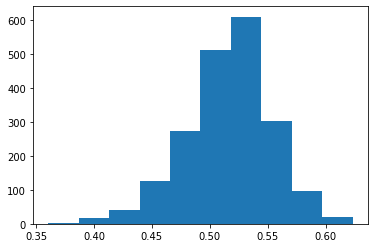

In [68]:
import matplotlib.pyplot as plt
plt.hist(y_predict_proba_home)
plt.show()

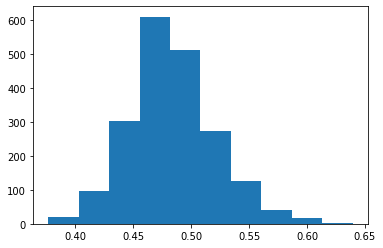

In [83]:
plt.hist(predict_proba_away)
plt.show()

In [72]:
df_19_proba[df_19_proba['model.results'] > .55][['game.winning.team', 'model.results']]

,game.winning.team,model.results
5,1,0.565819
7,1,0.558138
12,1,0.558272
15,0,0.551200
16,1,0.550226
...,...,...
1959,1,0.573062
1964,1,0.584769
1971,0,0.568846
1979,1,0.576244


# 2019 Predictions

In [36]:
# The model's predictions for the season
y_predict = gbm_final.predict(X_test, ntree_limit=gbm_final.best_ntree_limit)

In [57]:
np.sort(y_predict_proba)

array([0.3606473 , 0.38158178, 0.38831797, ..., 0.6122487 , 0.62008107,
       0.62319994], dtype=float32)

In [37]:
len(y_predict)

1999

In [38]:
# Add predictions to dataframe
df_19 = df_19.reset_index(drop = True)
df_19['model.results'] = pd.Series(y_predict)

In [39]:
df_19[['game.id', 'game.winning.team', 'model.results']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 3 columns):
game.id              1999 non-null object
game.winning.team    1999 non-null object
model.results        1999 non-null object
dtypes: object(3)
memory usage: 47.0+ KB


In [40]:
game_cols = ['game.id', 'game.scheduled', 'game.date', 'game.winning.team', 'game.home.name', 'game.away.name', 'away.team.league', 'home.team.league']

In [41]:
# Merge Predictions with FULL 2019 games dataset. This will have nulls
all_19_games = df_full[['game.id', 'game.scheduled', 'game.date', 'game.winning.team']][pd.to_datetime(df_full['game.date']).dt.year > 2018].drop_duplicates(keep = 'first').reset_index(drop = True)
games_19 = pd.merge(all_19_games, df_19[['game.id','model.results']], on = 'game.id', how = 'left')
games_19['model.results'] = games_19['model.results'].fillna('1')
# Add column containing Y/N for correct bet
games_19["win/loss"] = np.where(games_19['game.winning.team'] == games_19['model.results'], 1, 0)
print("Model Accuracy Score: ", accuracy_score(games_19['game.winning.team'], games_19['model.results']))
print("Baseline Accuracy Score: ", accuracy_score(games_19['game.winning.team'], home_predict(games_19['game.winning.team'])))

Model Accuracy Score:  0.562109375
Baseline Accuracy Score:  0.53125


In [42]:
games_19.shape

(2560, 6)

In [43]:
games_19.head()

,game.id,game.scheduled,game.date,game.winning.team,model.results,win/loss
0,e092d509-1f88-4a28-8906-86adf4dcb1c5,2019-03-20T17:07:00+00:00,2019-03-20,0,1,0
1,dd322dd5-c06b-4281-8ff4-85d2be9af10c,2019-03-21T17:05:00+00:00,2019-03-21,1,1,1
2,7e761e18-ffc1-4524-8b40-8b2f37421bae,2019-03-28T19:05:00+00:00,2019-03-28,1,1,1
3,778fb132-f85f-470d-abf2-2081c67c50a6,2019-03-30T20:05:00+00:00,2019-03-30,1,1,1
4,be79bfa7-78fe-4a77-8210-f59730aa82f9,2019-03-31T23:05:00+00:00,2019-03-31,1,1,1


In [44]:
def mulah_calc(series):
    return(series.value_counts()['yes']*90.91 - series.value_counts()['no']*100)

In [45]:
mulah_calc(games_19['win/loss'])

KeyError: 'yes'

In [46]:
# Add character columns
df_19_full = df_full[pd.to_datetime(df_game_sub['game.date']).dt.year > 2018].drop_duplicates(keep = 'first').reset_index(drop = True)
df_19_full = pd.merge(df_19_full, games_19[['game.id', 'model.results', 'win/loss']], on = 'game.id', how = 'left')
df_19_full.sort_values('game.date')
df_19_full.to_csv("2019_predictions.csv", index = False)

TypeError: unhashable type: 'list'

In [47]:
df_19_full['win/loss'] = df_19_full['win/loss'].replace("yes", 1)
df_19_full['win/loss'] = df_19_full['win/loss'].replace("no", 0)
df_19_full.head()

NameError: name 'df_19_full' is not defined

In [ ]:
df_19_full.to_csv("2019_predictions.csv", index = False)

# Mets Predictions

In [ ]:
df_19_mets = df_19_full[(df_19_full['game.home.name'] == 'Mets') | (df_19_full['game.away.name'] == 'Mets')].drop_duplicates(subset = 'game.id')


In [ ]:
# Mets predicted to lose = game.away.name = Mets, model result = 1
# Else Mets win

In [ ]:
df_19_mets['Mets Performance'] = np.where((df_19_mets['model.results'] == '1') & (df_19_mets['game.home.name'] == 'Mets'), 1, 0)


In [ ]:
df_19_mets['Mets Performance'].value_counts()

In [ ]:
mulah_calc(df_19_mets['win/loss'])

In [ ]:
df_19_mets.head()

In [ ]:
accuracy_score(df_19_mets['game.winning.team'], df_19_mets['model.results'])

In [ ]:
df_19_mets.to_csv("2019_mets_predictions.csv", index = False)

In [ ]:
print("Mets 2019 Accuracy Score: ", accuracy_score(y_test, gbm_final.predict(X_test, ntree_limit = gbm_final.best_ntree_limit)))
print("Train Accuracy Score: ", accuracy_score(y_train, gbm_final.predict(X_train, ntree_limit = gbm_final.best_ntree_limit)))
print("Baseline Accuracy Score: ", accuracy_score(y_test, home_predict(y_test)))

In [ ]:
df_baseline[df_baseline['game.home.name_Mets'] == 1]

In [ ]:
print("Baseline Training Accuracy Score: ", accuracy_score(y_train, home_predict(y_train)))

In [ ]:
games_19["win/loss"] = np.where(games_19['game.winning.team'] == games_19['model.results'], "yes", "no")

In [ ]:
games_19["win/loss"].value_counts()

In [ ]:
# Wagering $100 per game, a bettor loses $100 with a loss and wins $90.91 with a win
(90.91*1439) - (100*1121) 

In [ ]:
from sklearn.model_selection import cross_val_score
print("Cross Validation Score on Training Set: ", np.mean(cross_val_score(gbm2, X_train, y_train, cv = 10)))


In [ ]:
feature_importances = pd.DataFrame(gbm2.feature_importances_,index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
#len(feature_importances)
feature_importances[feature_importances['importance'] > 0]